In [2]:
from pathlib import Path
import urllib, tarfile, os, zipfile
import pandas as pd
from fastai.vision import *
from fastai.widgets import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)  # download the zip file
    tf = tarfile.open(fn)
    print('extracting', fn, '...')
    tf.extractall()

print("ChestXRay14 download complete.")

downloading images_01.tar.gz ...
extracting images_01.tar.gz ...
downloading images_02.tar.gz ...
extracting images_02.tar.gz ...
downloading images_03.tar.gz ...
extracting images_03.tar.gz ...
downloading images_04.tar.gz ...
extracting images_04.tar.gz ...
downloading images_05.tar.gz ...
extracting images_05.tar.gz ...
downloading images_06.tar.gz ...
extracting images_06.tar.gz ...
downloading images_07.tar.gz ...
extracting images_07.tar.gz ...
downloading images_08.tar.gz ...
extracting images_08.tar.gz ...
downloading images_09.tar.gz ...
extracting images_09.tar.gz ...
downloading images_10.tar.gz ...
extracting images_10.tar.gz ...
downloading images_11.tar.gz ...
extracting images_11.tar.gz ...
downloading images_12.tar.gz ...
extracting images_12.tar.gz ...
Download complete. Please check the checksums


In [3]:
path_img = Path("images")
path_img.ls()

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('images/00017903_006.png'),
 PosixPath('images/00015058_021.png'),
 PosixPath('images/00010308_005.png')]

In [ ]:
for idx, fname in fnames:
    if idx >= 2000: break
    shutil.copy(fname, "data/chest")

In [7]:
with zipfile.ZipFile("MURA-v1.1.zip","r") as zip_ref:
    zip_ref.extractall("mura")

In [13]:
path_mura = Path("MURA-v1.1")
path_mura.ls()

PosixPath('MURA-v1.1')

In [16]:
df_mura_train = pd.read_csv(path_mura/'train_image_paths.csv')
df_mura_train.head()

,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [22]:
mura_paths = [name for name in df_mura_train['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png']]
mura_paths[:5]

['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png',
 'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png',
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png',
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png',
 'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image3.png']

In [27]:
label_dest = {
    'SHOULDER': 'data/shoulder',
    'HUMERUS': 'data/shoulder',
    'FINGER': 'data/finger',
    'ELBOW': 'data/elbow',
    'WRIST': 'data/wrist',
    'FOREARM': 'data/forearm',
    'HAND': 'data/hand',
}

for idx, name in enumerate(mura_paths):
    for label in label_dest:
        if label in name:
            dest = label_dest[label]
        
    destfname = dest + "image" + str(idx) + ".png"
    shutil.copy(name, destfname)

In [4]:
path = Path('data/')
path.ls()

PosixPath('data')

In [18]:
np.random.seed(2)
tfms = get_transforms()
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=64, valid_pct=0.2).normalize(imagenet_stats)

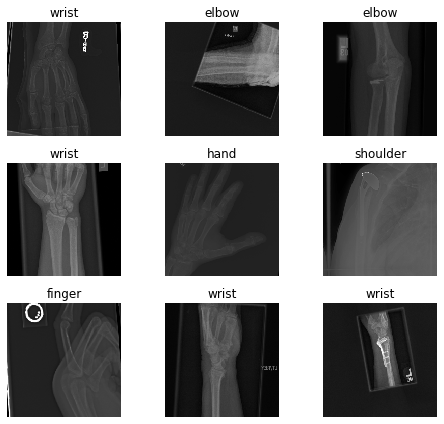

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)

['chest', 'elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']


(8, 8)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.422200,0.224062,0.070996,02:20
1,0.277975,0.158911,0.048576,02:14
2,0.201418,0.129584,0.037495,02:16
3,0.181865,0.118735,0.034145,02:14


In [40]:
learn.save('stage-1')

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

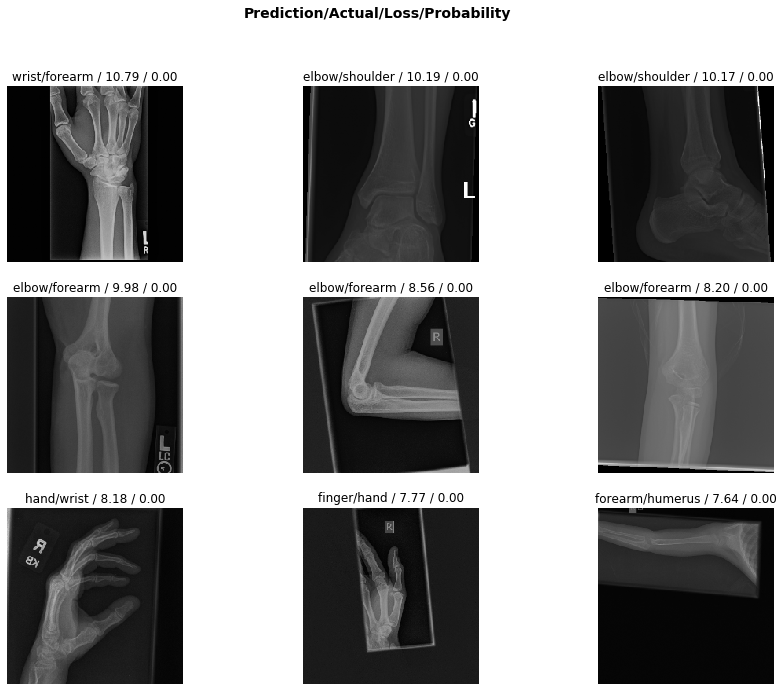

In [42]:
interp.plot_top_losses(9, figsize=(15,11))

TODO: Clean up data by following steps from lesson 2

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


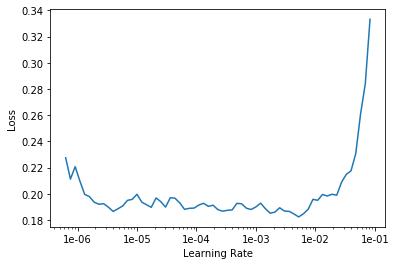

In [45]:
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.183774,0.107626,0.028862,02:53
1,0.103756,0.085424,0.022806,02:53


In [47]:
learn.save('stage-2')

In [9]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (31046 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hand,hand,hand,hand,hand
Path: data;

Valid: LabelList (7761 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
finger,wrist,forearm,wrist,hand
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

# Productionizing the model

In [10]:
learn.export()

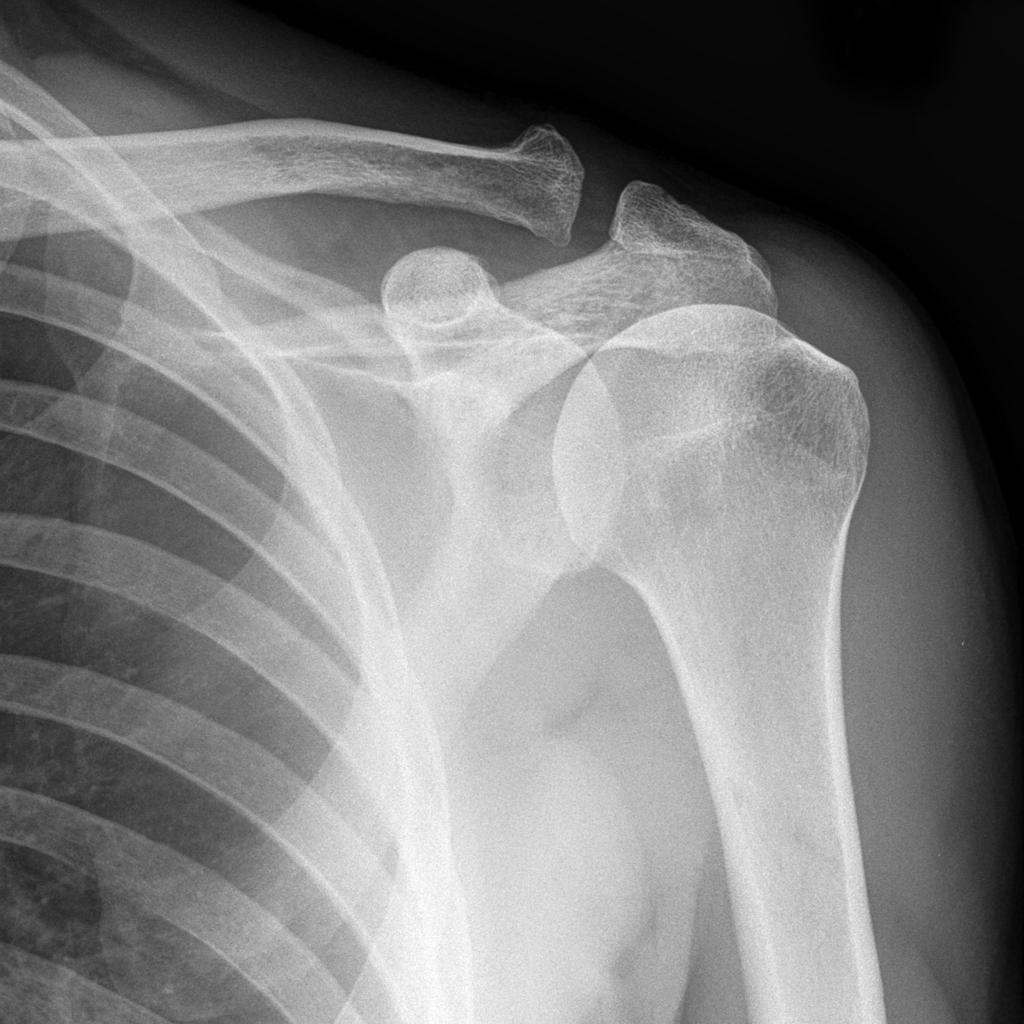

In [23]:
img = open_image('shoulder_xray.jpg')
img

In [ ]:
learn.load_learner('./')

In [12]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category shoulder,
 tensor(6),
 tensor([2.1117e-05, 1.4093e-06, 1.1432e-06, 2.2848e-06, 1.5110e-06, 8.6307e-04,
         9.9910e-01, 1.0795e-05]))

# Training with Mixed Precision

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.397240,0.235927,0.071383,03:44
1,0.282677,0.166131,0.049349,02:04
2,0.225584,0.128730,0.037237,02:04
3,0.181393,0.123455,0.034145,02:03


In [11]:
learn.save('stage-1-fp16')

# Training ResNet50

In [19]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


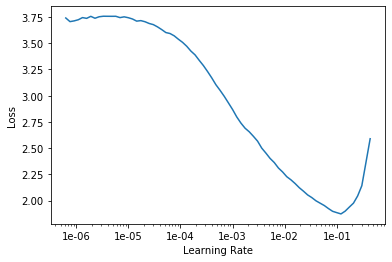

In [20]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.410887,0.188784,0.057982,04:27
1,0.250740,0.128860,0.038784,04:27
2,0.207341,0.108061,0.031697,04:25
3,0.169465,0.105474,0.030280,04:26


In [24]:
learn.save('resnet50')

In [25]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


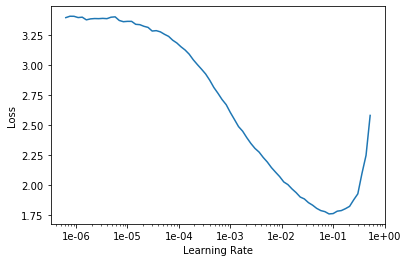

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.422384,0.221776,0.073315,02:35
1,0.259323,0.135947,0.042263,02:35
2,0.216018,0.110868,0.032857,02:35
3,0.161430,0.107798,0.031568,02:34


In [ ]:
learn.fit_one_cycle(2, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.187609,0.104634,0.032728,02:34
